In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, Ridge, SGDRegressor
from sklearn.metrics import root_mean_squared_log_error, root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, StackingRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
import xgboost as XGB
import lightgbm as lgb
import scipy.stats as stats
from datetime import datetime
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector, RFE, RFECV
from sklearn.inspection import permutation_importance

Importing training, testing datasets. 
Training set consists of 1.2 million samples and 20 features including Premium Amount
Test set consists of 800,000 samples

In [16]:
df = pd.read_csv('dataset/train.csv',index_col=0)
df_test = pd.read_csv('dataset/test.csv',index_col=0)
print('training data shape:',df.shape)
print('test data shape:',df_test.shape)

training data shape: (1200000, 20)
test data shape: (800000, 19)


## Plotting categorical features
The distribution of classes is quite even across features, with the exception of missing data. A lot of occupation data is missing.

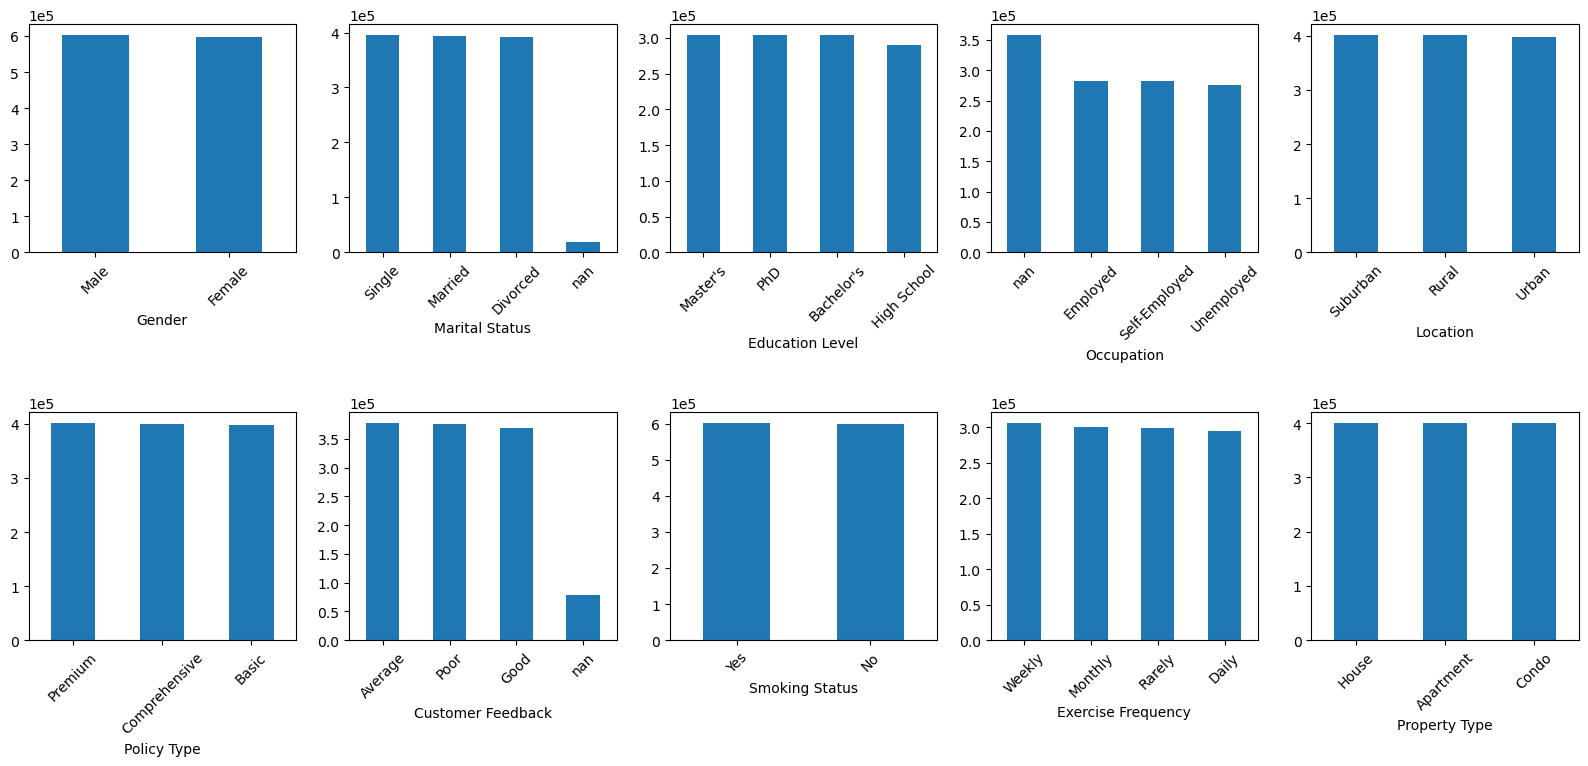

In [17]:
plt.figure(figsize=(20,8))
cat_cols = ['Gender','Marital Status', 'Education Level', 'Occupation','Location','Policy Type',
                'Customer Feedback', 'Smoking Status', 'Exercise Frequency','Property Type']
for i,c in enumerate(cat_cols):
    plt.subplot(2,5,i+1)
    df[c].value_counts(dropna=False).plot(kind='bar')
    plt.ticklabel_format(axis='y',scilimits=(0,0))
    plt.xticks(rotation=45)
plt.subplots_adjust(hspace=0.7)

## Plotting continuous features
Policy Start Date was converted to seconds since POSIX epoch so that it could be treated as a float. 
Age, Credit Score, Insurance Duration, Number of Dependents, Vehicle Age and Policy Start Date were all approximately uniformly distributed.
Annual Income, Premium Amount and Previous Claims were right-skewed
Health score was slightly right-skewed

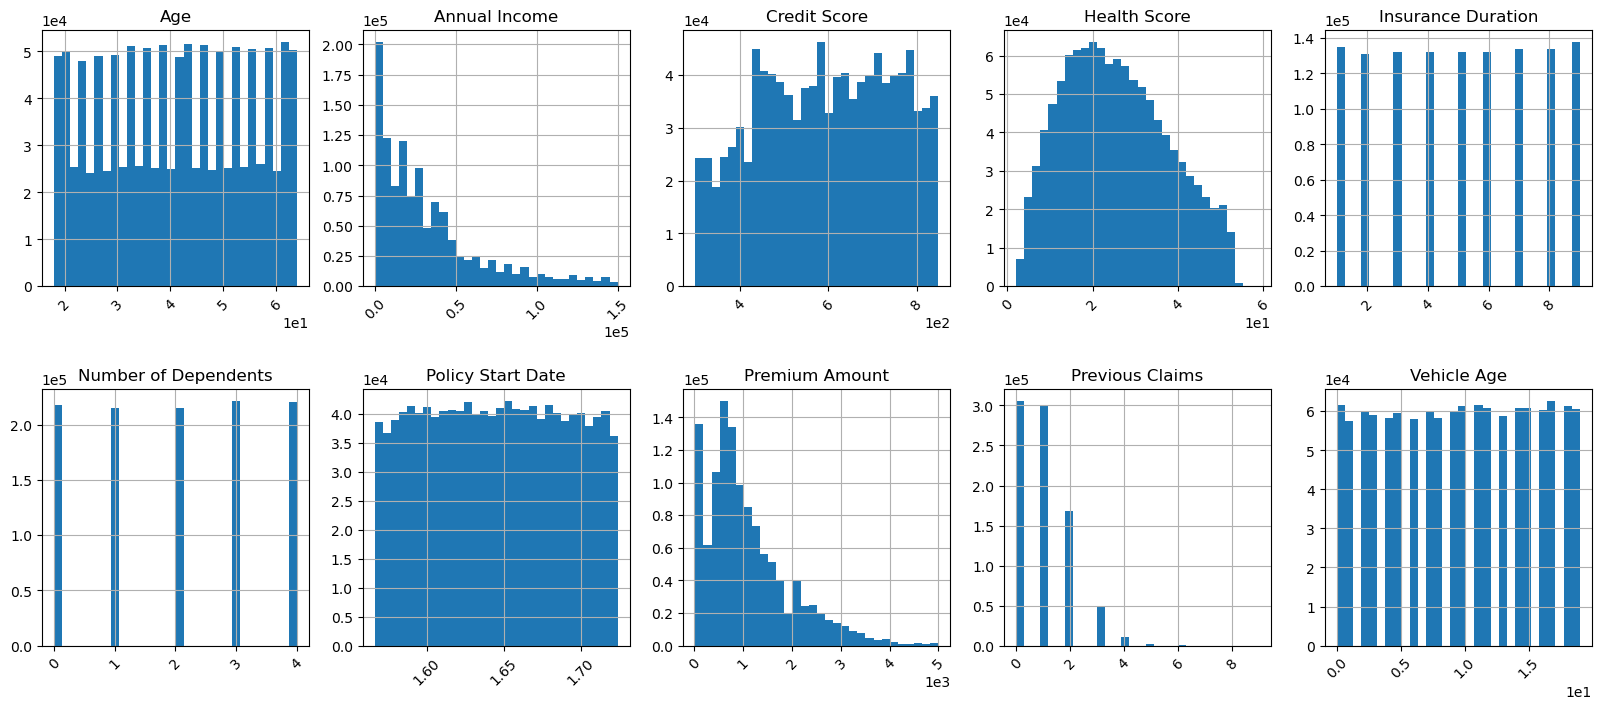

In [18]:
cont_cols = ['Age', 'Annual Income', 'Credit Score', 'Health Score',
       'Insurance Duration', 'Number of Dependents', 'Policy Start Date',
       'Premium Amount', 'Previous Claims', 'Vehicle Age']
df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date']).apply(lambda x: x.timestamp())
plt.figure(figsize=(20,8))
for i,c in enumerate(cont_cols):
    plt.subplot(2,5,i+1)
    if c == 'Policy Start Date':
        pd.to_datetime(df[c]).apply(lambda x: x.timestamp()).hist(bins=30)
    else:
        df[c].hist(bins=30)
    plt.title(c)
    plt.ticklabel_format(axis='both',scilimits=(0,0))
    plt.xticks(rotation=45)
plt.subplots_adjust(hspace=0.4)

## Missing values
Certain features have missing values, with Occupation and Previous Claims having 30% missing

In [19]:
pd.DataFrame(df.isna().mean().sort_values().apply(lambda x: '%.1f'%(100*x)),columns=['% missing'])

,% missing
Policy Type,0.0
Exercise Frequency,0.0
Smoking Status,0.0
Policy Start Date,0.0
Property Type,0.0
Location,0.0
Premium Amount,0.0
Education Level,0.0
Gender,0.0
Insurance Duration,0.0


## Preprocessing function
Based on the previous observations, a function to preprocess the data was prepared.

Previous claims had many missing values and few values greater than 2- to include these it was converted to categorical

In [20]:
def preprocess_data(df):
    cat_cols = ['Gender','Marital Status', 'Education Level', 'Occupation','Location','Policy Type',
                'Customer Feedback', 'Smoking Status', 'Exercise Frequency','Property Type']
    # convert text features to categorical dtype after replacing missing values with new class
    for c in cat_cols:
        df[c] = df[c].fillna('missing').astype('category')
    
    df['Previous Claims'] = df['Previous Claims'].clip(0,2).replace({np.nan:'missing',0:'none',1:'one',2:'two_or_more'}).astype('category')

    cat_cols.append('Previous Claims')

    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date']).apply(lambda x: x.timestamp())

    cont_cols = np.setdiff1d(df.columns,cat_cols)
    # impute missing values for remaining continuous features
    df[cont_cols] = df[cont_cols].fillna(df[cont_cols].median())

    # convert categorical features to binary features, remove redundant features
    df = pd.get_dummies(df,columns=cat_cols)

    df['Annual Income'] =  stats.boxcox(df['Annual Income'])[0]
    df['Health Score'] = stats.boxcox(df['Health Score'])[0]

    return df

In [21]:
df = preprocess_data(df)
df_test = preprocess_data(df_test)

(array([2.00000e+01, 2.56300e+03, 1.88400e+03, 1.24800e+03, 3.31400e+03,
        2.17400e+04, 2.85890e+04, 3.28580e+04, 2.59360e+04, 4.53910e+04,
        4.36520e+04, 4.49550e+04, 5.02870e+04, 4.71440e+04, 4.93330e+04,
        8.43110e+04, 6.89090e+04, 1.15671e+05, 9.64290e+04, 6.00760e+04,
        8.03330e+04, 6.38140e+04, 3.93760e+04, 3.84220e+04, 3.51830e+04,
        3.39980e+04, 2.63670e+04, 1.94290e+04, 2.12670e+04, 1.75010e+04]),
 array([ 0.        ,  3.20782248,  6.41564496,  9.62346745, 12.83128993,
        16.03911241, 19.24693489, 22.45475737, 25.66257986, 28.87040234,
        32.07822482, 35.2860473 , 38.49386978, 41.70169227, 44.90951475,
        48.11733723, 51.32515971, 54.53298219, 57.74080468, 60.94862716,
        64.15644964, 67.36427212, 70.5720946 , 73.77991709, 76.98773957,
        80.19556205, 83.40338453, 86.61120701, 89.8190295 , 93.02685198,
        96.23467446]),
 <BarContainer object of 30 artists>)

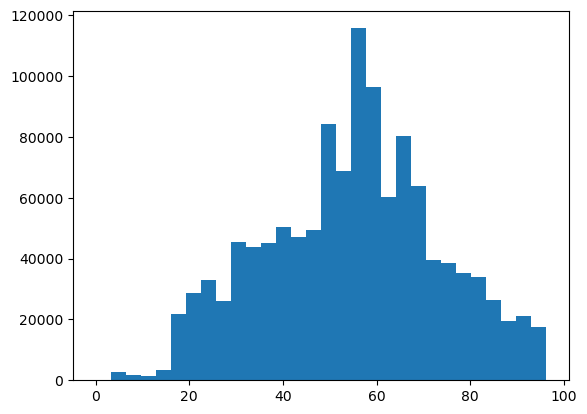

In [45]:
plt.hist(df['Annual Income'],bins=30)

(array([2.25000e+02, 5.01300e+03, 1.17420e+04, 1.58720e+04, 2.14620e+04,
        2.26410e+04, 2.93460e+04, 3.83350e+04, 3.71370e+04, 5.13910e+04,
        5.20890e+04, 5.04120e+04, 5.84080e+04, 6.42210e+04, 6.66800e+04,
        1.35631e+05, 6.38980e+04, 6.02120e+04, 5.79750e+04, 5.73480e+04,
        5.49720e+04, 4.66250e+04, 4.32880e+04, 4.14690e+04, 3.42490e+04,
        3.12140e+04, 2.65300e+04, 2.08260e+04, 7.62000e+02, 2.70000e+01]),
 array([ 0.87548122,  1.46684208,  2.05820294,  2.6495638 ,  3.24092466,
         3.83228551,  4.42364637,  5.01500723,  5.60636809,  6.19772895,
         6.7890898 ,  7.38045066,  7.97181152,  8.56317238,  9.15453324,
         9.74589409, 10.33725495, 10.92861581, 11.51997667, 12.11133752,
        12.70269838, 13.29405924, 13.8854201 , 14.47678096, 15.06814181,
        15.65950267, 16.25086353, 16.84222439, 17.43358525, 18.0249461 ,
        18.61630696]),
 <BarContainer object of 30 artists>)

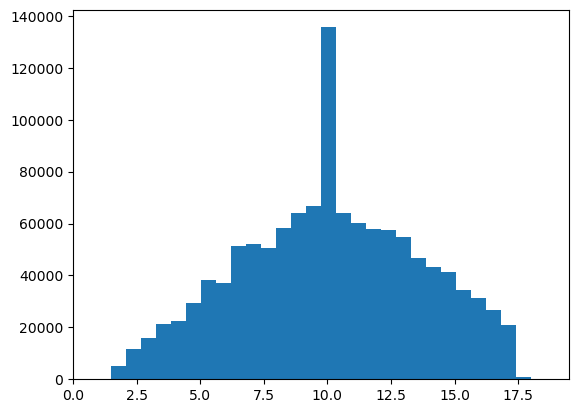

In [46]:
plt.hist(df['Health Score'],bins=30)

## Target definition
Premium Amount is the prediction target. The performance metric is the root mean square log error (RMSLE).
It differs from root mean square error (RMSE)in that RMSLE will penalize under-estimation more than over-estimation. To get good performance, we want to optimize our models for the squared log loss rather than the squared loss. However, squared loss is more commonly available as a loss in different ML algorithms. We can therefore take the log of the target in advance, so that we are effectively optimizing for RMSLE.


In [22]:
target = df['Premium Amount']
# competition metric is root mean square log loss -> log-transform target first so that can use common mean-squares losses to optimize for the root mean square log loss
# will convert back predictions later
transformed_target = np.log1p(target)
X = df.drop(columns='Premium Amount')
Y = transformed_target = np.log1p(target)

(1080000, 45)


## Model fitting
Optimization using grid search and experiments with feature subsets were conducted. Minimal improvement was observed, and the biggest difference was between algorithms.

In [47]:
reg = LassoCV(eps=1e-5,cv=5)
pipe = Pipeline([('scaler',StandardScaler()),('reg',reg)])
print('%.4f'%np.mean(cross_val_score(pipe,X,Y,scoring='neg_root_mean_squared_error',cv=5)))

-1.0901


In [48]:
reg = HistGradientBoostingRegressor(categorical_features='from_dtype',l2_regularization=0.1,max_features=0.8,max_iter=500)
pipe = Pipeline([('scaler',StandardScaler()),('reg',reg)])
print('%.4f'%np.mean(cross_val_score(pipe,X,Y,scoring='neg_root_mean_squared_error',cv=5)))

-1.0479


In [52]:
reg = SGDRegressor(max_iter=1000,early_stopping=True)
pipe = Pipeline([('scaler',StandardScaler()),('reg',reg)])
print('%.4f'%np.mean(cross_val_score(pipe,X,Y,scoring='neg_root_mean_squared_error',cv=5)))

-1.0922


In [53]:
reg = XGB.XGBRegressor()
pipe = Pipeline([('scaler',StandardScaler()),('reg',reg)])
print('%.4f'%np.mean(cross_val_score(pipe,X,Y,scoring='neg_root_mean_squared_error',cv=5)))

-1.0487


In [54]:
reg = RandomForestRegressor(n_jobs=-1,max_leaf_nodes=30,max_features=0.8,max_samples=0.1)
pipe = Pipeline([('scaler',StandardScaler()),('reg',reg)])
print('%.4f'%np.mean(cross_val_score(pipe,X,Y,scoring='neg_root_mean_squared_error',cv=5)))

-1.0493


## Stacking models
Creating ensembles of different model algorithms was also explored. Any improvement was minor, at the expense of longer run time.

In [55]:
pipe = Pipeline([('scaler',StandardScaler()),('stack',StackingRegressor([
    ('lasso',LassoCV(eps=1e-5,cv=5)),
    ('HistGBR',HistGradientBoostingRegressor(categorical_features='from_dtype',l2_regularization=0.1,max_features=0.8,max_iter=500)),
    ('SGD',SGDRegressor(max_iter=1000,early_stopping=True)),
    ('XGB',XGB.XGBRegressor())],verbose=3,cv=3,n_jobs=-1))])
print('%.4f'%np.mean(cross_val_score(pipe,X,Y,scoring='neg_root_mean_squared_error',cv=5)))

-1.0470


In [56]:
pipe = Pipeline([('scaler',StandardScaler()),('stack',StackingRegressor([
    ('HistGBR',HistGradientBoostingRegressor(categorical_features='from_dtype',l2_regularization=0.1,max_features=0.8,max_iter=500)),
    ('XGB',XGB.XGBRegressor())],verbose=3,cv=3,n_jobs=-1))])
print('%.4f'%np.mean(cross_val_score(pipe,X,Y,scoring='neg_root_mean_squared_error',cv=5)))

-1.0469


In [57]:
pipe = Pipeline([('scaler',StandardScaler()),('stack',StackingRegressor([
    ('HistGBR',HistGradientBoostingRegressor(categorical_features='from_dtype',l2_regularization=0.1,max_features=0.8,max_iter=500)),
    ('XGB',XGB.XGBRegressor())],verbose=3,cv=3,n_jobs=-1)),
    ('rf', RandomForestRegressor(n_jobs=-1,max_leaf_nodes=30,max_features=0.8,max_samples=0.1))])
print('%.4f'%np.mean(cross_val_score(pipe,X,Y,scoring='neg_root_mean_squared_error',cv=5)))

-1.0504


## Selected model for submission: Hist Gradient Boosting Regressor


In [28]:
importance = permutation_importance(reg,xtest,ytest,scoring='neg_mean_squared_error',n_jobs=-1)
importance.pop('importances')
importance = pd.DataFrame().from_dict(importance)
importance.index = xtrain.columns

<Axes: >

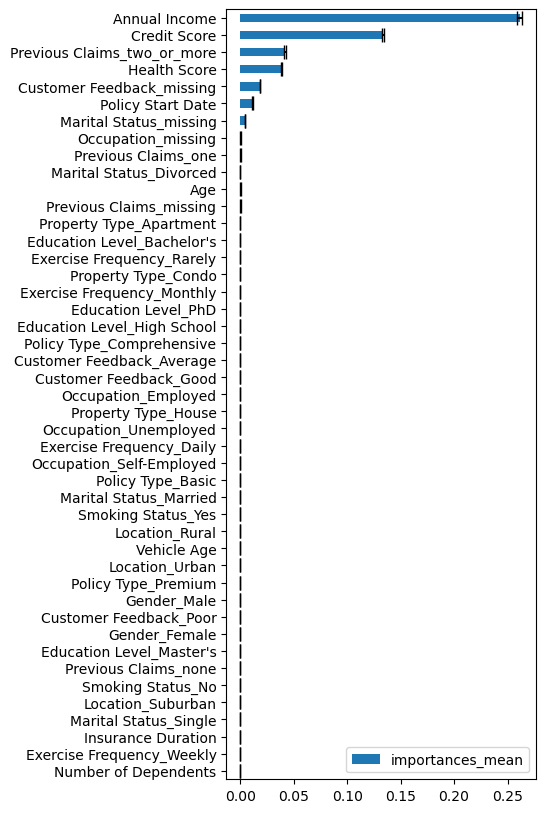

In [29]:
importance.sort_values(by='importances_mean').plot(kind='barh',xerr='importances_std',capsize=5,figsize=(4,10))

In [30]:
reg = HistGradientBoostingRegressor(categorical_features='from_dtype',l2_regularization=0.1)
t0 = datetime.now()
reg.fit(xtrain[top10_cols],ytrain)
print('train:',root_mean_squared_error(ytrain,reg.predict(xtrain[top10_cols])))
print('test:',root_mean_squared_error(ytest,reg.predict(xtest[top10_cols])))
print(datetime.now()-t0)

train: 1.0465496706419883
test: 1.0458054166880308
0:00:08.825485


In [31]:
contrib_features = importance.loc[importance.importances_mean > 0].sort_values(
    by='importances_mean',ascending=False).index

In [56]:
res = pd.DataFrame()
reg = HistGradientBoostingRegressor(categorical_features='from_dtype',l2_regularization=0.1)
t0 = datetime.now()
for i in range(len(contrib_features),1,-1):
    print(i)
    reg.fit(xtrain[contrib_features[:i]],ytrain)
    tr = root_mean_squared_error(ytrain,reg.predict(xtrain[contrib_features[:i]]))
    te = root_mean_squared_error(ytest,reg.predict(xtest[contrib_features[:i]]))
    print('train:',tr)
    print('test:',te)
    print(datetime.now()-t0)
    res = pd.concat([res,pd.Series({'tr':tr,'te':te,'features':contrib_features[:i]}).to_frame().T])


27
train: 1.046504208327944
test: 1.0464834785540953
0:00:13.302314
26
train: 1.0451491517669018
test: 1.0451312000559612
0:00:25.944169
25
train: 1.0457442651265407
test: 1.0455637913915008
0:00:37.668985
24
train: 1.0465664531941692
test: 1.0464175772612208
0:00:48.976405
23
train: 1.0456959696722745
test: 1.045390018690793
0:01:00.857209
22
train: 1.0465415896701575
test: 1.0461962902035775
0:01:12.505538
21
train: 1.0453480695559005
test: 1.0452526702535319
0:01:23.711433
20
train: 1.046458905375182
test: 1.0455580472183714
0:01:32.774076
19
train: 1.0469729885238137
test: 1.0464341031537643
0:01:43.305625
18
train: 1.0463109641937478
test: 1.0460313367297946
0:01:54.188029
17
train: 1.0454222572986511
test: 1.0451456079296118
0:02:04.020787
16
train: 1.0449709641013663
test: 1.044842779866095
0:02:14.342543
15
train: 1.0454583112787206
test: 1.0451235816200017
0:02:24.324523
14
train: 1.044812044977204
test: 1.044807778401833
0:02:33.777612
13
train: 1.0455506199477307
test: 1.044

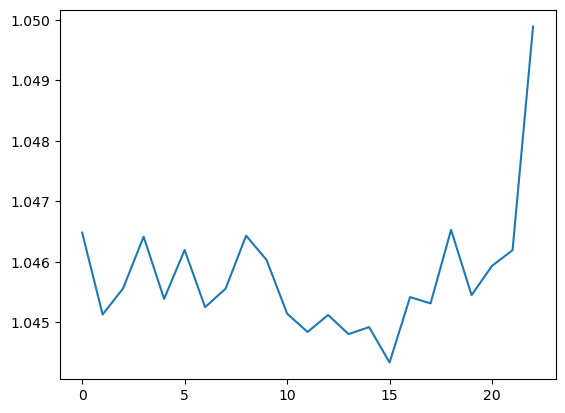

In [61]:
plt.plot(res['te'].values[:-3])

In [63]:
res = pd.DataFrame()
reg = HistGradientBoostingRegressor(categorical_features='from_dtype',l2_regularization=0.1,
                                    min_samples_leaf=1,max_leaf_nodes=100)
t0 = datetime.now()
for i in range(len(contrib_features),1,-1):
    print(i)
    reg.fit(xtrain[contrib_features[:i]],ytrain)
    tr = root_mean_squared_error(ytrain,reg.predict(xtrain[contrib_features[:i]]))
    te = root_mean_squared_error(ytest,reg.predict(xtest[contrib_features[:i]]))
    print('train:',tr)
    print('test:',te)
    print(datetime.now()-t0)
    res = pd.concat([res,pd.Series({'tr':tr,'te':te,'features':contrib_features[:i]}).to_frame().T])


27
train: 1.0434657856928733
test: 1.0462258695172415
0:00:11.375540
26
train: 1.039806405673729
test: 1.045936353938157
0:00:25.748838
25
train: 1.0436518994822446
test: 1.0460957167276685
0:00:35.150407
24
train: 1.040255485598951
test: 1.0459596206456396
0:00:47.242348
23
train: 1.0424583514866808
test: 1.0460090929908175
0:00:56.750720
22
train: 1.0421952855787022
test: 1.0465329172847981
0:01:07.376608
21
train: 1.0411378614021467
test: 1.0463110501458162
0:01:19.193508
20
train: 1.0410761963746518
test: 1.0460648686622556
0:01:31.081438
19
train: 1.0428431190884162
test: 1.045870912664176
0:01:39.478625
18
train: 1.0414431663573034
test: 1.0456121442684283
0:01:50.041129
17
train: 1.0427328420101374
test: 1.0464003290060622
0:01:59.681258
16
train: 1.0406117385050944
test: 1.0447987117845805
0:02:08.852325
15
train: 1.04058870306294
test: 1.0459732063798284
0:02:19.372544
14
train: 1.0417622658095984
test: 1.0459023987131488
0:02:29.343195
13
train: 1.042513481553164
test: 1.0461

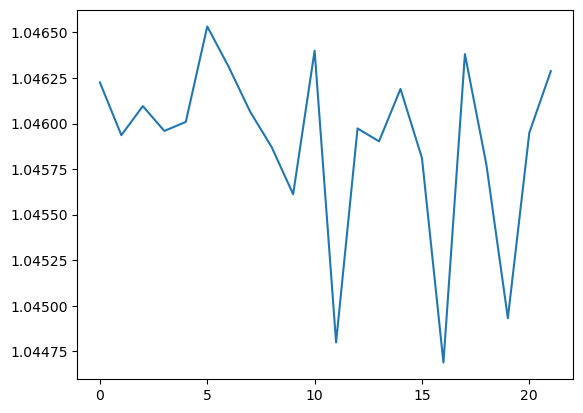

In [69]:
plt.plot(res['te'].values[:-4])

In [64]:
# BEST {'model__learning_rate': 0.1,
# 'model__max_leaf_nodes': 31,
# 'model__min_samples_leaf': 20}
# {'model__l2_regularization': 0.1, 'model__max_features': 1.0}

reg = Pipeline([('scaler',StandardScaler()),('model',HistGradientBoostingRegressor(categorical_features='from_dtype'))])
param_grid = {#'model__learning_rate':[1,0.1,0.01],
              'model__max_leaf_nodes':[31,60,120,240]}
              #'model__min_samples_leaf':[20,40,80]}
              #'model__max_features':[1.0,0.9,0.8],
              #'model__l2_regularization':[0.,0.1,1]}
cv = GridSearchCV(reg,param_grid=param_grid,scoring='neg_mean_squared_error',n_jobs=-1,cv=3,verbose=3)
t0 = datetime.now()
cv.fit(xtrain,ytrain)
print('train:',root_mean_squared_error(ytrain,cv.best_estimator_.predict(xtrain)))
print('test:',root_mean_squared_error(ytest,cv.best_estimator_.predict(xtest)))
print(datetime.now()-t0)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
train: 1.044921484431872
test: 1.0449959303804675
0:02:22.066645


In [75]:
res = pd.Series()
reg = HistGradientBoostingRegressor(categorical_features='from_dtype',l2_regularization=0.1)
t0 = datetime.now()
for i in range(len(contrib_features),1,-1):
    print(i)
    score = np.mean(cross_val_score(reg, X[contrib_features[:i]],Y,cv=3,n_jobs=-1,scoring='neg_root_mean_squared_error'))
    print(score)
    res[i] = score
res


27
-1.0477815818429268
26
-1.0468488584609825
25
-1.0480390819312684
24
-1.0476617907777748
23
-1.0480873087540763
22
-1.047843943203728
21
-1.0476894474058098
20
-1.0482967026209848
19
-1.0476253992840574
18
-1.0476066275388574
17
-1.048115382821264
16
-1.0480539680797027
15
-1.0480548001501544
14
-1.0476080865702755
13
-1.0480604404678897
12
-1.0475872369819534
11
-1.047192577280695
10
-1.0477828709409656
9
-1.047723760823512
8
-1.0478021691397315
7
-1.0471148684885598
6
-1.04924307179671
5
-1.05307106492228
4
-1.0563528197524208
3
-1.065509391230813
2
-1.0723564577897997


27   -1.047782
26   -1.046849
25   -1.048039
24   -1.047662
23   -1.048087
22   -1.047844
21   -1.047689
20   -1.048297
19   -1.047625
18   -1.047607
17   -1.048115
16   -1.048054
15   -1.048055
14   -1.047608
13   -1.048060
12   -1.047587
11   -1.047193
10   -1.047783
9    -1.047724
8    -1.047802
7    -1.047115
6    -1.049243
5    -1.053071
4    -1.056353
3    -1.065509
2    -1.072356
dtype: float64

In [32]:
# BEST {'model__learning_rate': 0.1,
# 'model__max_leaf_nodes': 31,
# 'model__min_samples_leaf': 20}
# {'model__l2_regularization': 0.1, 'model__max_features': 1.0}

reg = Pipeline([('scaler',StandardScaler()),('model',HistGradientBoostingRegressor(categorical_features='from_dtype'))])
param_grid = {#'model__learning_rate':[1,0.1,0.01],
              'model__max_leaf_nodes':[31,300,None]}
              #'model__min_samples_leaf':[20,40,80]}
              #'model__max_features':[1.0,0.9,0.8],
              #'model__l2_regularization':[0.,0.1,1]}
gs = GridSearchCV(reg,param_grid=param_grid,scoring='neg_mean_squared_error',n_jobs=-1,cv=5,verbose=3)
t0 = datetime.now()
gs.fit(xtrain,ytrain)
print('train:',root_mean_squared_error(ytrain,gs.best_estimator_.predict(xtrain)))
print('test:',root_mean_squared_error(ytest,gs.best_estimator_.predict(xtest)))
print(datetime.now()-t0)
print(gs.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
train: 1.0446292023254071
test: 1.0445209285278252
0:07:54.243807
{'model__max_leaf_nodes': 31}


In [34]:
# BEST {'model__learning_rate': 0.1,
# 'model__max_leaf_nodes': 31,
# 'model__min_samples_leaf': 20}
# {'model__l2_regularization': 0.1, 'model__max_features': 1.0}

reg = Pipeline([('scaler',StandardScaler()),('model',HistGradientBoostingRegressor(categorical_features='from_dtype'))])
param_grid = {'model__learning_rate':[0.02,0.1,0.5]}
              #'model__max_leaf_nodes':[31,300,None]}
              #'model__min_samples_leaf':[20,40,80]}
              #'model__max_features':[1.0,0.9,0.8],
              #'model__l2_regularization':[0.,0.1,1]}
gs = GridSearchCV(reg,param_grid=param_grid,scoring='neg_mean_squared_error',n_jobs=-1,cv=5,verbose=3)
t0 = datetime.now()
gs.fit(xtrain,ytrain)
print('train:',root_mean_squared_error(ytrain,gs.best_estimator_.predict(xtrain)))
print('test:',root_mean_squared_error(ytest,gs.best_estimator_.predict(xtest)))
print(datetime.now()-t0)
print(gs.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
train: 1.045835602493389
test: 1.0457463941183076
0:03:06.467091
{'model__learning_rate': 0.1}


In [35]:
# BEST {'model__learning_rate': 0.1,
# 'model__max_leaf_nodes': 31,
# 'model__min_samples_leaf': 20}
# {'model__l2_regularization': 0.1, 'model__max_features': 1.0}

reg = Pipeline([('scaler',StandardScaler()),('model',HistGradientBoostingRegressor(categorical_features='from_dtype'))])
param_grid = {#'model__learning_rate':[0.02,0.1,0.5],
              #'model__max_leaf_nodes':[31,300,None]}
              #'model__min_samples_leaf':[20,40,80]}
              'model__max_features':[1.0,0.9,0.8]}
              #'model__l2_regularization':[0.,0.1,1]}
gs = GridSearchCV(reg,param_grid=param_grid,scoring='neg_mean_squared_error',n_jobs=-1,cv=5,verbose=3)
t0 = datetime.now()
gs.fit(xtrain,ytrain)
print('train:',root_mean_squared_error(ytrain,gs.best_estimator_.predict(xtrain)))
print('test:',root_mean_squared_error(ytest,gs.best_estimator_.predict(xtest)))
print(datetime.now()-t0)
print(gs.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
train: 1.0456533984014453
test: 1.0458208953800319
0:03:25.684942
{'model__max_features': 0.8}


In [36]:
# BEST {'model__learning_rate': 0.1,
# 'model__max_leaf_nodes': 31,
# 'model__min_samples_leaf': 20}
# {'model__l2_regularization': 0.1, 'model__max_features': 1.0}

reg = Pipeline([('scaler',StandardScaler()),('model',HistGradientBoostingRegressor(categorical_features='from_dtype'))])
param_grid = {#'model__learning_rate':[0.02,0.1,0.5],
              #'model__max_leaf_nodes':[31,300,None]}
              #'model__min_samples_leaf':[20,40,80]}
              #'model__max_features':[1.0,0.9,0.8]}
              'model__l2_regularization':[0.,0.1,1]}
gs = GridSearchCV(reg,param_grid=param_grid,scoring='neg_mean_squared_error',n_jobs=-1,cv=5,verbose=3)
t0 = datetime.now()
gs.fit(xtrain,ytrain)
print('train:',root_mean_squared_error(ytrain,gs.best_estimator_.predict(xtrain)))
print('test:',root_mean_squared_error(ytest,gs.best_estimator_.predict(xtest)))
print(datetime.now()-t0)
print(gs.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
train: 1.046136526590094
test: 1.0462855523640746
0:03:23.447502
{'model__l2_regularization': 0.1}


In [38]:
reg = HistGradientBoostingRegressor(categorical_features='from_dtype',l2_regularization=0.1,max_features=0.8,max_iter=500)
t0 = datetime.now()
reg.fit(xtrain,ytrain)
print('train:',root_mean_squared_error(ytrain,reg.predict(xtrain)))
print('test:',root_mean_squared_error(ytest,reg.predict(xtest)))
print(datetime.now()-t0)

train: 1.0449425669926369
test: 1.0457468882666312
0:00:15.069992


In [41]:
reg = Pipeline([('a',StandardScaler()),('b',HistGradientBoostingRegressor(categorical_features='from_dtype',l2_regularization=0.1,max_features=0.8,max_iter=500))])
t0 = datetime.now()
reg.fit(xtrain,ytrain)
print('train:',root_mean_squared_error(ytrain,reg.predict(xtrain)))
print('test:',root_mean_squared_error(ytest,reg.predict(xtest)))
print(datetime.now()-t0)

train: 1.0466021569799908
test: 1.0461379909377442
0:00:13.539298


In [43]:
reg = HistGradientBoostingRegressor(categorical_features='from_dtype',l2_regularization=0.1,max_features=0.8,max_iter=500)
t0 = datetime.now()
print(np.mean(cross_val_score(reg,X,Y,scoring='neg_root_mean_squared_error',cv=5)))b

-1.047861358315825


In [44]:
reg = Pipeline([('a',StandardScaler()),('b',HistGradientBoostingRegressor(categorical_features='from_dtype',l2_regularization=0.1,max_features=0.8,max_iter=500))])
t0 = datetime.now()
print(np.mean(cross_val_score(reg,X,Y,scoring='neg_root_mean_squared_error',cv=5)))

-1.0478426867739385
